# Описание проекта
**Определение стоимости автомобилей**

Сервис по продаже автомобилей с пробегом `«Не бит, не крашен»` разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. 


В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Нам нужно построить модель для определения стоимости. 

Также у нас установлены критерии, которые важны заказчику:

- `качество предсказания`;
- `скорость предсказания`;
- `время обучения`

## Подготовка данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, make_scorer

In [2]:
data = pd.read_csv('/datasets/autos.csv')
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


**Описание данных**

**`Признаки`**
* `DateCrawled` — дата скачивания анкеты из базы;
* `VehicleType` — тип автомобильного кузова;
* `RegistrationYear` — год регистрации автомобиля;
* `Gearbox` — тип коробки передач;
* `Power` — мощность (л. с.);
* `Model` — модель автомобиля;
* `Kilometer` — пробег (км);
* `RegistrationMonth` — месяц регистрации автомобиля;
* `FuelType` — тип топлива;
* `Brand` — марка автомобиля;
* `NotRepaired` — была машина в ремонте или нет;
* `DateCreated` — дата создания анкеты;
* `NumberOfPictures` — количество фотографий автомобиля;
* `PostalCode` — почтовый индекс владельца анкеты (пользователя);
* `LastSeen` — дата последней активности пользователя;


**`Целевой признак`**
* `Price` — цена (евро)


In [3]:
def my_info(x, y):  # аргумент x примет значение сохраненного датасета в переменной;
                    # аргумент y примет описательный характер датасета, по которому будет описываться информация
    print(y)
    display(x.head())
    print(f'Размер {y}: {x.shape}')
    print()
    print(f'Информация о {y}:')
    print()
    display(x.info())
    display(x.describe())
    print(f'Кол-во пропущенных значений в {y}:') 
    display(x.isna().sum())
    print()
    print(f'Кол-во дубликатов в {y}: {x.duplicated().sum()}')
    
    
my_info(data, 'data')

data


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


Размер data: (354369, 16)

Информация о data:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           35

None

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Кол-во пропущенных значений в data:


DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
NotRepaired          71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64


Кол-во дубликатов в data: 4


* Для дальнейшей предобработки данных приведем колонки в нижний регистр для удобства (еще создадим размер объектов в начале, чтобы сравнить его с результатом в конце)

In [4]:
data.columns = data.columns.str.lower()
begin_shape = data.shape[0]

data.head()

,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired,datecreated,numberofpictures,postalcode,lastseen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


* `Выведем дубликаты, а также и долю пропусков в колонках при помощи внедренной функции в созданный датафрейм из пропусков`

In [5]:
print(data.duplicated().sum())
data[data.duplicated()]

4


,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired,datecreated,numberofpictures,postalcode,lastseen
171088,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08 00:00:00,0,89518,2016-03-09 09:46:57
231258,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28 00:00:00,0,66589,2016-03-28 08:46:21
258109,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03 00:00:00,0,75196,2016-04-07 09:44:54
325651,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18 00:00:00,0,36391,2016-03-18 18:46:15


In [6]:
columns_isna = pd.DataFrame(data[['vehicletype', 'gearbox', 'model', 'fueltype', 'notrepaired']].isna().mean())
columns_isna.columns = ['isna']

def my_func(x):
    return f'{x:.2%}'

columns_isna['isna'] = columns_isna['isna'].apply(my_func)
columns_isna

,isna
vehicletype,10.58%
gearbox,5.60%
model,5.56%
fueltype,9.28%
notrepaired,20.08%


* Получились достаточно большие доли пропусков в колонках. Особенно в колонке `'notrepaired'` более **20%**. Это большие доли, чтобы их удалять. А так как мы не можем никак их воспроизвести, то поставим на место пропусков заглушку - **unknown**
* Также избавимся от дубликатов

In [7]:
data = data.drop_duplicates().reset_index(drop=True)
data.duplicated().sum()

0

In [8]:
data[['vehicletype', 'gearbox', 'model', 'fueltype', 'notrepaired']] = data[['vehicletype', 
                                                                             'gearbox', 'model', 
                                                                             'fueltype', 
                                                                             'notrepaired']].fillna('unknown')

data[['vehicletype', 'gearbox', 'model', 'fueltype', 'notrepaired']].isna().sum()

vehicletype    0
gearbox        0
model          0
fueltype       0
notrepaired    0
dtype: int64

In [9]:
data['gearbox'].value_counts().to_frame()

,gearbox
manual,268249
auto,66283
unknown,19833


**Теперь проверим датасет на аномальные значения**

* Создадим срез из количественных колонок датасета;
* Создадим функцию, которая будет выводить диаграмму размаха и описание данной колонки. С ее помощью посмотрим на выбросы и аномальные значения

Признак: price

count    354365.000000
mean       4416.679830
std        4514.176349
min           0.000000
25%        1050.000000
50%        2700.000000
75%        6400.000000
max       20000.000000
Name: price, dtype: float64


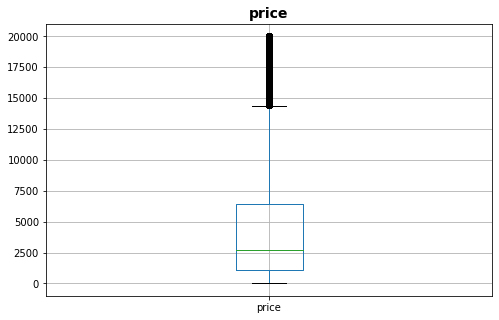

Признак: registrationyear

count    354365.000000
mean       2004.234481
std          90.228466
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: registrationyear, dtype: float64


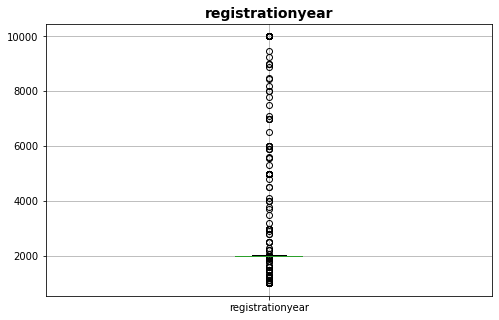

Признак: power

count    354365.000000
mean        110.093816
std         189.851330
min           0.000000
25%          69.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: power, dtype: float64


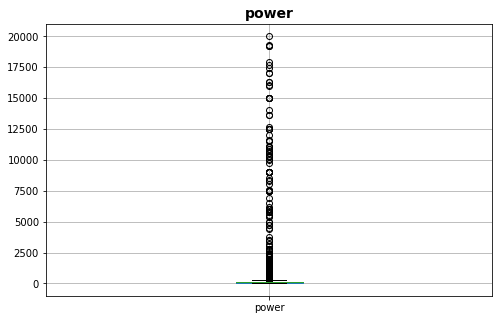

Признак: kilometer

count    354365.000000
mean     128211.363989
std       37905.083858
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: kilometer, dtype: float64


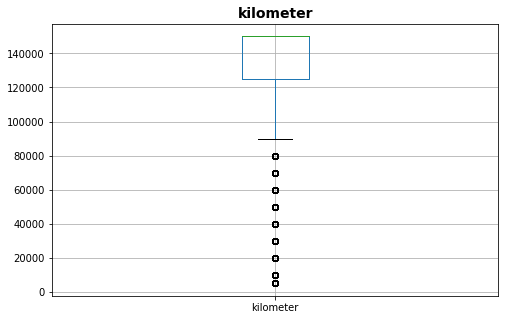

Признак: registrationmonth

count    354365.000000
mean          5.714650
std           3.726432
min           0.000000
25%           3.000000
50%           6.000000
75%           9.000000
max          12.000000
Name: registrationmonth, dtype: float64


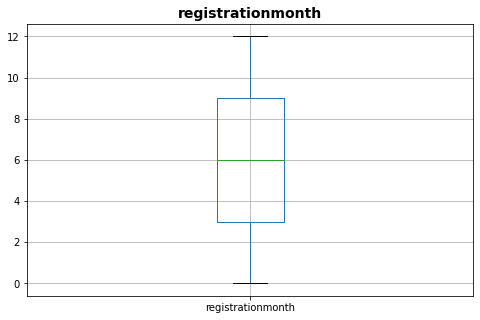

Признак: numberofpictures

count    354365.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: numberofpictures, dtype: float64


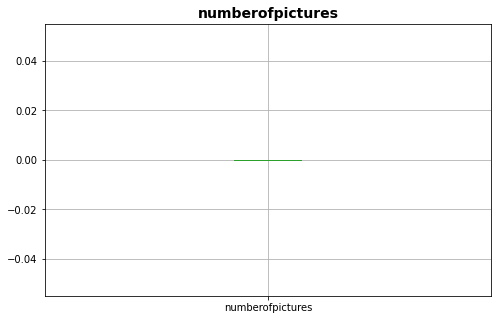

In [10]:
numeric_columns = data[['price', 'registrationyear', 'power', 'kilometer', 
                        'registrationmonth', 'numberofpictures']]

def boxplot(data):
    
    for i in numeric_columns.columns:
        
        data.boxplot(i, figsize=(8, 5))
        
        print(f'Признак: {i}')
        print()
        print(data[i].describe())
        
        plt.title(i, fontweight='bold', fontsize=14)
        plt.show();
        
boxplot(data)

In [11]:
#data.plot(y='price', kind='hist', histtype='step', bins=50, figsize=(10, 7));
display(data.loc[data['price'] == 0, 'price'].count())
print(data['price'].count())
print(round((10772 / 354365) * 100, 2), '%')

10772

354365
3.04 %


In [12]:
display(data.groupby(data['price'].sort_values())['price'].agg('count').to_frame())
data.loc[(data['price'] >= 0)&(data['price'] <= 1050), 'price'].count() # смотрим до среднего значения

,price
price,
0,10772
1,1189
2,12
3,8
4,1
...,...
19995,10
19997,1
19998,6


88744

* Обнаружили, что **кол-во продаж за 0 евро** составляет около **3%** от общего числа. Также присутствуют данные о продажах и за 1 евро. Посмотрим на распределение **90%** значений, то есть с 0.05 по 0.95 квантиля

In [13]:
data['price'].quantile([0.05, 0.95])

0.05      200.0
0.95    14600.0
Name: price, dtype: float64

In [14]:
display(data.loc[(data['price'] >= 200)&(data['price'] <= 14600), 'price'].count())
print(round( ((abs(319251 - 354365)) / 354365) * 100, 2), '%')

319251

9.91 %


In [15]:
data.query('price <= 200')['price'].count()

19448

* Высчитали процент строк, который не входит в этот **90%** диапазон значений. По диаграмме размаха, мы видим, что аномалии присутствуют около 14600. Но это слишком много данных, чтобы удалять их. Ставим цену минимальную 200 евро по 5-ому квантилю

In [16]:
data = data.query('price >= 200').reset_index(drop=True)
data['price'].describe()

count    336903.000000
mean       4643.642063
std        4515.355328
min         200.000000
25%        1250.000000
50%        2950.000000
75%        6650.000000
max       20000.000000
Name: price, dtype: float64

* Следующий признак `'registrationyear'`. **Очень много выбросов**. Наблюдаем годы продаж машин, когда было еще Монголо-татарское иго. Видимо, так оно и захватило большую часть Евразии. Конечно, эти года нужно устранить

In [17]:
data['registrationyear'].unique()

array([1993, 2011, 2004, 2001, 2008, 1995, 2014, 1998, 2005, 1910, 2016,
       2007, 2009, 2002, 2018, 1997, 1990, 2017, 1981, 2003, 1994, 1991,
       1984, 2006, 1999, 2012, 2010, 2000, 1992, 2013, 1996, 1989, 2015,
       1985, 1982, 1976, 1983, 1973, 1969, 1971, 1987, 1988, 1980, 1970,
       1986, 1965, 1945, 1925, 1974, 1979, 1955, 1978, 1972, 1968, 1977,
       1961, 1966, 1975, 1963, 1964, 1960, 1958, 1967, 1956, 3200, 1941,
       9999, 8888, 1500, 2200, 4100, 1962, 1929, 1957, 1940, 2066, 1949,
       2019, 1937, 1951, 1800, 1959, 1953, 1954, 1234, 5300, 9000, 2900,
       6000, 5900, 1000, 5911, 1400, 5000, 4000, 1948, 1952, 8500, 1932,
       1950, 3700, 3800, 4800, 1942, 7000, 1935, 1933, 1936, 3000, 1923,
       2290, 1930, 1001, 9450, 1944, 2500, 1943, 1938, 1934, 1928, 5555,
       1600, 1111, 1039, 2800, 1931, 4500, 1602, 7800, 1947, 1927, 7100,
       1300, 8200, 1946])

* Мы можем по признаку `'datacrawled'` выявить дату скачивания анкеты, и таким образом установить максимальную дату поколения машины, то есть год, в который были выгружены эти данные, и соответственно, машина не может быть старше выгруженных в интернет данных. Минимум мы проверить, к сожалению, не можем, так как выгрузить можно было их в любое время. 

* Создание первой машины `29 января 1886`. Не будем вдаваться в подробности, ограничим этим годом

In [18]:
data['datecrawled'].max()

'2016-04-07 14:36:58'

In [19]:
data = data.loc[(data['registrationyear'] >= 1886)&(data['registrationyear'] <= 2016), :].reset_index(drop=True)
data.describe()

,price,registrationyear,power,kilometer,registrationmonth,numberofpictures,postalcode
count,323248.000000,323248.000000,323248.000000,323248.000000,323248.000000,323248.0,323248.000000
mean,4697.856107,2002.676716,113.080341,128329.796317,5.866038,0.0,50831.214102
std,4546.120155,6.832733,184.844812,37184.272709,3.659752,0.0,25731.668246
min,200.000000,1910.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1265.000000,1999.000000,75.000000,125000.000000,3.000000,0.0,30539.000000
50%,2999.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49661.000000
75%,6800.000000,2007.000000,143.000000,150000.000000,9.000000,0.0,71364.000000
max,20000.000000,2016.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [20]:
data['registrationyear'].quantile([0.05, 0.95])

0.05    1993.0
0.95    2013.0
Name: registrationyear, dtype: float64

* Наблюдаем выбросы, но не уверены, как может повлиять на качество модели. Оставим, как есть, так как снова много данных


* Следующий признак `power`. Здесь наблюдаются очень большие значения похожие на аномальные. Опираясь на информацию за 2016 год (https://www.lowsound.ru/samaya-bystraya-mashina-v-mire-2016-goda.html), **самым мощным (л.с.) на 2016 является 1250 л. с.**

In [21]:
display(data.groupby(data['power'].sort_values())['power'].agg('count').to_frame())
data.loc[data['power'] <= 1250, 'power'].count()

,power
power,
0,30214
1,21
2,9
3,8
4,30
...,...
17932,1
19208,1
19211,1


323043

* Очень **много** данных с **0 мощностью**. Но этого явно **не может** быть, машина с **0 л.с**, поэтому устраним эти объекты

In [22]:
data = data.query('0 < power <= 1250').reset_index(drop=True)
data.shape[0]

292829

* Построим для этих признаков гистограммы, чтобы посмотреть распределение

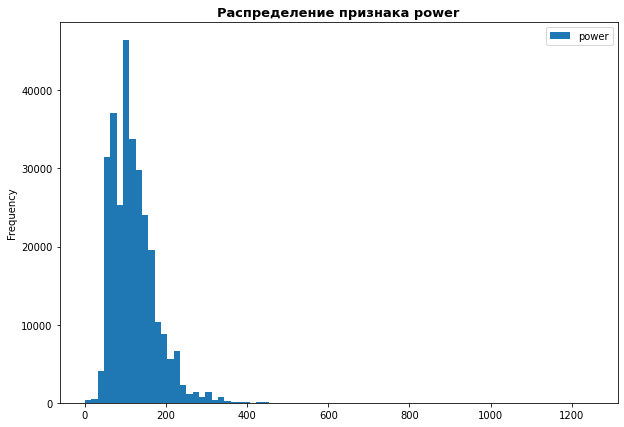

In [23]:
def hist(column, name):
    
    data[column].plot(kind='hist', bins=80, figsize=(10, 7), label=name, legend=True)
    plt.title('Распределение признака' +' '+ name, fontweight='bold', fontsize=13)
    
hist('power', 'power')    

In [24]:
data.loc[data['power'] > 400, 'power'].count()

440

Видим явные выбросы после 400 л.с. **Устраним** их и не навредим объему данных

In [25]:
data = data.query('power <= 400').reset_index(drop=True)

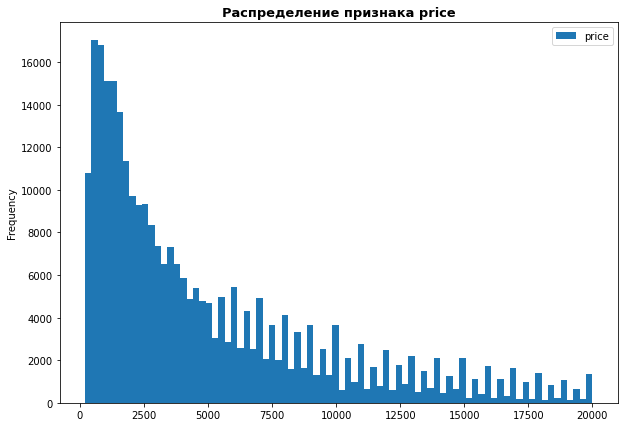

In [26]:
hist('price', 'price') # проверяем цену

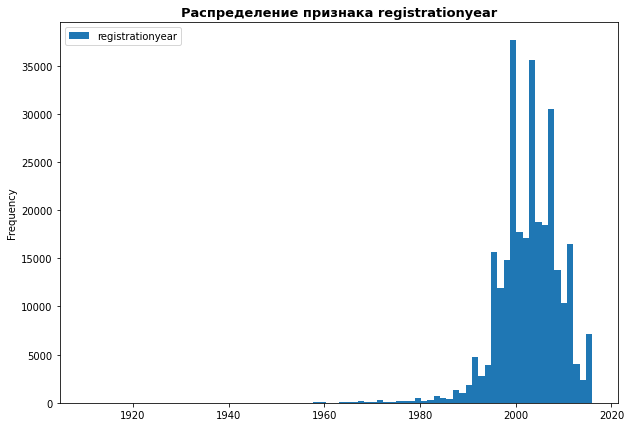

In [27]:
hist('registrationyear', 'registrationyear')

In [28]:
print(data.query('registrationyear < 1960')['registrationyear'].count())
data = data.query('registrationyear >= 1960').reset_index(drop=True)
data.shape[0]

145


292244

In [29]:
data.corr()

,price,registrationyear,power,kilometer,registrationmonth,numberofpictures,postalcode
price,1.000000,0.494090,0.505345,-0.391264,0.064657,NaN,0.063922
registrationyear,0.494090,1.000000,0.131712,-0.301835,0.043351,NaN,0.028655
power,0.505345,0.131712,1.000000,0.111926,0.038779,NaN,0.054728
kilometer,-0.391264,-0.301835,0.111926,1.000000,-0.014996,NaN,-0.010853
registrationmonth,0.064657,0.043351,0.038779,-0.014996,1.000000,NaN,0.001848
numberofpictures,NaN,NaN,NaN,NaN,NaN,NaN,NaN
postalcode,0.063922,0.028655,0.054728,-0.010853,0.001848,NaN,1.000000


* Также зааметили в признаке с годом регистрации автомобиля `registrationyear` выбросы. Это небольшой объем данных, его удаление логично и никак не навредит;
* В признаке с ценой `price` не все так однозначно. Там много данных, которые решили оставить;
* Остальные признаки не понадобятся для моделей, так как почти никак не коррелируют с целевым признаком, а некоторые просто не явлются информативными, а только будут нагружать модель. **Удалим их**

In [30]:
data = data.drop(['datecrawled', 'registrationmonth', 'datecreated', 'numberofpictures', 'postalcode', 'lastseen'],
                 axis=1)

end_shape = data.shape[0]
shape = (abs(end_shape - begin_shape)) / begin_shape
print(f'Доля удаленных объектов из датасета: {shape:.3%}')

Доля удаленных объектов из датасета: 17.531%


### Вывод

* Загрузили данные;
* Привели признаки в нижний регистр;
* Удалили дубликаты и выявили процент пропусков по колонкам;
* Проанализировав пропуски, поставили на них зуглушку **unknown**;
* Разобрали количественные признаки на аномалии и выбросы с помощью диаграммы размаха и гистограмм;
* Удалили не нужные признаки для модели `'datecrawled', 'registrationmonth', 'datecreated', 'numberofpictures', 'postalcode', 'lastseen'`
* По итогу доля удаленных объектов составила **17.5%**. Это достаточно много, однако все сделано придерживаясь определенной логике (можно было пойти по пути замены большого кол-ва **0-ых значений** в признаке мощности `power` медианным значением по столбцу, но качество нужно проверять)

## Обучение моделей

**Подготовим признаки для обучения моделей**

* Создаем кодированные признаки (категориальные признаки в численные) путем прямого кодирования **OHE** и порядковым кодированием **OrdinalEncoder**

Для начала копируем датасет для порядкового кодирования и прямого в говорящие переменные **data_ordinal и data_for_ohe** для дальнейшего использования в моделях деревьев и линейной регрессии

In [31]:
data_ordinal = data.copy() # для моделей деревьев
data_for_ohe = data.copy()

In [32]:
data_ohe = pd.get_dummies(data_for_ohe, drop_first=True) # drop_first=True во избежание ловушки
data_ohe

,price,registrationyear,power,kilometer,vehicletype_convertible,vehicletype_coupe,vehicletype_other,vehicletype_sedan,vehicletype_small,vehicletype_suv,...,brand_smart,brand_sonstige_autos,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,notrepaired_unknown,notrepaired_yes
0,18300,2011,190,125000,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,9800,2004,163,125000,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
2,1500,2001,75,150000,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
3,3600,2008,69,90000,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,650,1995,102,150000,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292239,5250,2016,150,150000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
292240,3200,2004,225,150000,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
292241,1199,2000,101,125000,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
292242,9200,1996,102,150000,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


* Очень раздуло таблицу. Попробуем удалить признак с моделью **model** и оставим только марку **brand**, предиктивная сила у модели все равно будет

In [33]:
data_for_ohe = data_for_ohe.drop('model', axis=1)
data_ohe = pd.get_dummies(data_for_ohe, drop_first=True)
data_ohe

,price,registrationyear,power,kilometer,vehicletype_convertible,vehicletype_coupe,vehicletype_other,vehicletype_sedan,vehicletype_small,vehicletype_suv,...,brand_smart,brand_sonstige_autos,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,notrepaired_unknown,notrepaired_yes
0,18300,2011,190,125000,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,9800,2004,163,125000,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
2,1500,2001,75,150000,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
3,3600,2008,69,90000,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,650,1995,102,150000,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292239,5250,2016,150,150000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
292240,3200,2004,225,150000,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
292241,1199,2000,101,125000,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
292242,9200,1996,102,150000,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


* Теперь таблица не такая большая с **62 признаками**, можно делить ее на выборки


Теперь создадим категориальные признаки, которые будем преобразовывать в численные. Выделим их в отдельную переменную **cat_features**, передадим скопированному датасету **data_ordinal** и выведем результат, который тоже можно будет делить на выборки

In [34]:
cat_features = ['vehicletype', 'gearbox', 'model', 'fueltype', 'brand', 'notrepaired']

encoder = OrdinalEncoder()
data_ordinal[cat_features] = pd.DataFrame(encoder.fit_transform(data_ordinal[cat_features]), 
                                          columns=data_ordinal[cat_features].columns)
data_ordinal

,price,vehicletype,registrationyear,gearbox,power,model,kilometer,fueltype,brand,notrepaired
0,18300,2.0,2011,1.0,190,227.0,125000,2.0,1.0,2.0
1,9800,6.0,2004,0.0,163,117.0,125000,2.0,14.0,1.0
2,1500,5.0,2001,1.0,75,116.0,150000,6.0,38.0,0.0
3,3600,5.0,2008,1.0,69,101.0,90000,2.0,31.0,0.0
4,650,4.0,1995,1.0,102,11.0,150000,6.0,2.0,2.0
...,...,...,...,...,...,...,...,...,...,...
292239,5250,7.0,2016,0.0,150,4.0,150000,7.0,0.0,0.0
292240,3200,4.0,2004,1.0,225,140.0,150000,6.0,30.0,2.0
292241,1199,1.0,2000,0.0,101,106.0,125000,6.0,32.0,0.0
292242,9200,0.0,1996,1.0,102,223.0,150000,2.0,38.0,0.0


In [35]:
data.head()

,price,vehicletype,registrationyear,gearbox,power,model,kilometer,fueltype,brand,notrepaired
0,18300,coupe,2011,manual,190,unknown,125000,gasoline,audi,yes
1,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,unknown
2,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
3,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
4,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes


**Разделим на выборки датасеты с помощью функции** 

* Чтобы обучение происходило быстрее и качество модели улучшалось, масштабируем признаки для выборок (конечно, это лучше всего для линейных моделей, так как моделям деревьев особой разницы нет, но проведем масштабирование для всех выборок

In [36]:
def tts(data, name): # аргумент data принимает датасет кодированный, а аргумент name несет описательный характер
    
    features = data.drop('price', axis=1)
    target = data['price']
    
    features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25, 
                                                                                random_state=12345)
    
    print(f'Train выборка {name}: {features_train.shape}, {target_train.shape}') # проверяем разделение/размер выборок
    print(f'Test выборка {name}: {features_test.shape}, {target_test.shape}')
    print()
    
    scaler = StandardScaler()
    scaler.fit(features_train) # обучаем всегда на обучающей выборке
    features_train = pd.DataFrame(scaler.transform(features_train), columns=features_train.columns)
    features_test = pd.DataFrame(scaler.transform(features_test), columns=features_test.columns)
    
    return features_train, features_test, target_train, target_test

In [37]:
features_train_ohe, features_test_ohe, target_train_ohe, target_test_ohe = tts(data_ohe, 'data_ohe')

Train выборка data_ohe: (219183, 61), (219183,)
Test выборка data_ohe: (73061, 61), (73061,)



In [38]:
features_train_ord, features_test_ord, target_train_ord, target_test_ord = tts(data_ordinal, 'data_ordinal')

Train выборка data_ordinal: (219183, 9), (219183,)
Test выборка data_ordinal: (73061, 9), (73061,)



* Для моделей градиентного бустинга создаем выборки, где не будут категориальные признаки превращены в численные, которые мы передадим в саму модель

In [39]:
features = data.drop('price', axis=1)
target = data['price']

features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25, 
                                                                            random_state=12345)

In [40]:
features_train_ord.head()

,vehicletype,registrationyear,gearbox,power,model,kilometer,fueltype,brand,notrepaired
0,-1.893312,1.728890,0.424934,-0.126963,0.736093,0.593025,-1.490236,0.471668,-0.515688
1,-1.893312,0.015938,0.424934,0.196371,1.570759,0.593025,1.162507,1.293583,-0.515688
2,-1.893312,0.638830,-1.909885,0.367548,0.051940,0.593025,-1.490236,1.293583,-0.515688
3,-0.233348,1.728890,0.424934,-0.298140,-1.152170,-2.672626,0.631959,-1.471039,-0.515688
4,1.426615,0.794553,0.424934,-0.640494,0.407699,0.593025,-0.429139,-1.097441,-0.515688


In [41]:
features_train.head()

,vehicletype,registrationyear,gearbox,power,model,kilometer,fueltype,brand,notrepaired
231038,bus,2014,manual,114,other,150000,gasoline,renault,no
238491,bus,2003,manual,131,unknown,150000,unknown,volkswagen,no
204566,bus,2007,auto,140,golf,150000,gasoline,volkswagen,no
242503,sedan,2014,manual,105,a3,30000,petrol,audi,no
177716,wagon,2008,manual,87,logan,150000,lpg,dacia,no


### Вывод

* Применили технику кодирования **OHE и OrdinalEncoder** признаков, по которому категориальные признаки превратились в численные;
* Путем анализа сделали сокращение в датасете по прямому кодированию **data_ohe** путем удаления признака **model** `(было 311 признаков стало 62)`;
* Вывели категориальные признаки в отдельную переменную **cat_features** с помощью которой и превратили в численные техникой порядкового кодирования;
* С помощью функции **tts** разделили датасеты на выборки, которые с помощью **StandardScaler** были приведены к **одному масштабу**, чтобы `алгоритм не посчитал, что какой-то признак важнее`
* Создали отдельно выборки для моделей **Градиентного бустинга**

## Анализ моделей

Теперь приступаем к обучению моделей

Параметры будем подбирать с помощью **GridSearchCV**

В задаче сказано, что для `оценки качества моделей применятся метрика` **RMSE**. Значение метрики **RMSE** `должно быть меньше` **2500**.

* Введем функцию, которая будет расчитывать метрику **RMSE**

In [42]:
def rmse(target, predict):
    mse = mean_squared_error(target, predict)
    rmse = np.sqrt(mse)
    
    return rmse

* Создаем функцию для рассчитывания параметров и лучшего значения для **rmse**. Считать будем при помощи **`GridSearchCV()`**. Эта техника обучает модель с заданными нами в перечни параметрами, из которых выберет лучшие для метрики **rmse**, используя кросс валидацию, так как большая выборка (после проведем финальную проверку на тестовой). 

* С помощью параметра `make_scorer()` внесем расчетную метрику - нашу **функцию rmse** (хотя внутренняя функция, по которой обучается модель является встроенной функцией потерь (скорее всего MSE)), а также параметр `greater_is_better=False` (принято ставить `greater_is_better=False` для метрик, которые являются лоссами). Так как на выходе получается отрицательное число, приводим его в абсолютное с помощью `abs()`, чтобы не посчитал иначе при использовании этого параметра.

* Лучшее значение **rmse** выводим с помощью атрибута `.best_score_`, а лучшие параметры с помощью `.best_params_`

На вход функция принимает **6 аргументов**: `сама модель`, `перечень параметров`, `признаки`, `целевой признак`, `название модели` и `тип кодирования`. С ее помощью мы найдем лучшее значение **RMSE** с лучшими гиперпараметрами. Затем мы выберем топ лучших модель по значениям и выявим время обучения и предсказания, также проверим на тестовой выборке

In [43]:
def best_model(model, params, features, target, model_name, cod_name):
    
    cvs = GridSearchCV(model, params, scoring=make_scorer(rmse, greater_is_better=False), cv=5)
    
    cvs.fit(features, target)
    
    print(f'Лучшие параметры модели {model_name} при {cod_name} кодировании: {cvs.best_params_}')
    print()
    print(f'Лучший RMSE модели {model_name} при {cod_name} кодировании: {round(abs(cvs.best_score_), 4)}')
    print()

* **Находим лучшее значение модели Решающего Дерева с ее гиперпараметрами**

In [44]:
%%time

model_dtr = DecisionTreeRegressor(random_state=12345)

params_dtr = {'max_depth': range(8, 12), 'min_samples_leaf': range(6, 8), 'min_samples_split': range(5, 7)}

best_model(model_dtr, params_dtr, features_train_ord, target_train_ord, 'Решающего Дерева', 'порядковом')

Лучшие параметры модели Решающего Дерева при порядковом кодировании: {'max_depth': 11, 'min_samples_leaf': 6, 'min_samples_split': 5}

Лучший RMSE модели Решающего Дерева при порядковом кодировании: 1897.7593

CPU times: user 24.1 s, sys: 37.4 ms, total: 24.1 s
Wall time: 24.1 s


* **Теперь смотрим на модель Случайного Леса на выборках, который были закодированы порядковым методом**

In [45]:
%%time

model_rfr = RandomForestRegressor(random_state=12345)

params_rfr = {'max_depth': range(10, 11), 'min_samples_leaf': range(7, 8), 
              'min_samples_split': range(5, 6), 'n_estimators': range(100, 101)}

best_model(model_rfr, params_rfr, features_train_ord, target_train_ord, 'Случайного Леса', 'порядковом')

Лучшие параметры модели Случайного Леса при порядковом кодировании: {'max_depth': 10, 'min_samples_leaf': 7, 'min_samples_split': 5, 'n_estimators': 100}

Лучший RMSE модели Случайного Леса при порядковом кодировании: 1849.3872

CPU times: user 2min 3s, sys: 167 ms, total: 2min 3s
Wall time: 2min 4s


* Посмотрим как будет меняться значение **RMSE** модели **DummyRegressor** со стратегией квантиля

In [46]:
%%time

model_dr = DummyRegressor(strategy='quantile')

params_dr = {'quantile':np.arange(0.0, 1.0, 0.1)}

best_model(model_dr, params_dr, features_train_ohe, target_train_ohe, 'Дамми Регрессора', 'прямом')

Лучшие параметры модели Дамми Регрессора при прямом кодировании: {'quantile': 0.6000000000000001}

Лучший RMSE модели Дамми Регрессора при прямом кодировании: 4618.7973

CPU times: user 1.18 s, sys: 1.19 s, total: 2.36 s
Wall time: 2.37 s


**DummyRegressor** показал себя совсем слабо

* Теперь возьмем модель **Линейной Регрессии** на двух выборках (прямое и порядковое кодирование)

In [47]:
%%time

model_lr = LinearRegression()

params_lr = {'normalize': [True, False]}

best_model(model_lr, params_lr, features_train_ohe, target_train_ohe, 'Линейной Регрессии', 'прямом')

Лучшие параметры модели Линейной Регрессии при прямом кодировании: {'normalize': True}

Лучший RMSE модели Линейной Регрессии при прямом кодировании: 2702.9242

CPU times: user 15.6 s, sys: 13.4 s, total: 29 s
Wall time: 29 s


In [48]:
%%time

model_lr_ord = LinearRegression()

params_lr_ord = {'normalize': [True, False]}

best_model(model_lr_ord, params_lr_ord, features_train_ord, target_train_ord, 'Линейной Регрессии', 'порядковом')

Лучшие параметры модели Линейной Регрессии при порядковом кодировании: {'normalize': True}

Лучший RMSE модели Линейной Регрессии при порядковом кодировании: 2879.9605

CPU times: user 1.02 s, sys: 1.15 s, total: 2.17 s
Wall time: 2.14 s


* Среди всех моделей не градиентного бустинга лучше всего себя по значению **RMSE** показала модель **Случайного Леса**
* Теперь посмотрим модели градиентного бустинга

Начнем с **CatBoostRegressor**

In [49]:
%%time


model_ctr = CatBoostRegressor(loss_function='RMSE', cat_features=cat_features, verbose=False, random_state=12345)
#model_ctr.fit(features_train, target_train, cat_features=cat_features, verbose=30)

params_ctr = {'iterations': range(80, 151, 35), 'max_depth': range(9, 12, 2)}

best_model(model_ctr, params_ctr, features_train, target_train, 'CatBoostRegressor', 'отсутствующем')

Подобрали параметры. Теперь узнаем время обучения и предсказания, а также значение метрики **RMSE**

In [50]:
%%time

model_ctr = CatBoostRegressor(loss_function='RMSE', iterations=150, max_depth=11, random_state=12345)
model_ctr.fit(features_train, target_train, cat_features=cat_features, verbose=50)

Learning rate set to 0.448606
0:	learn: 3236.7273589	total: 250ms	remaining: 37.2s
50:	learn: 1470.5144071	total: 7.41s	remaining: 14.4s
100:	learn: 1373.4804665	total: 14.1s	remaining: 6.86s
149:	learn: 1318.2500057	total: 20.8s	remaining: 0us
CPU times: user 21 s, sys: 188 ms, total: 21.2 s
Wall time: 21.9 s


In [51]:
%%time 

predict_ctr = model_ctr.predict(features_train)
rmse_ctr = rmse(target_train, predict_ctr)
print(rmse_ctr)

1333.0385503070138
CPU times: user 355 ms, sys: 7.86 ms, total: 363 ms
Wall time: 367 ms


* Рассмотрим модель **LightGBM**

In [52]:
%%time

model_lgbm = LGBMRegressor(learning_rate=0.1)

params_lgbm = {'max_depth': [11, 15], 'n_estimators': [70, 90]}

best_model(model_lgbm, params_lgbm, features_train_ord, target_train_ord, 'LGMB', 'порядковом')

* Подобрали гиперпараметры для модели **LGBM**. Теперь так же, как и для модели **CatBoost**, вычисляем время обучения и предсказания

In [53]:
%%time

model_lgbm = LGBMRegressor(max_depth=15, n_estimators=90, learning_rate=0.1)
model_lgbm.fit(features_train_ord, target_train_ord)

CPU times: user 1min 7s, sys: 356 ms, total: 1min 8s
Wall time: 1min 9s


LGBMRegressor(max_depth=15, n_estimators=90)

In [54]:
%%time

predict_lgbm = model_lgbm.predict(features_train_ord)
rmse_lgbm = rmse(target_train_ord, predict_lgbm)
print(rmse_lgbm)

1648.8527037741833
CPU times: user 1.4 s, sys: 0 ns, total: 1.4 s
Wall time: 1.39 s


Среди моделей `не бустинга`, лучше всего показали себя модели деревьев - **Решающее Дерево и Случайный Лес**. Проверим их на тествой выборке, и вычислим `время обучения и предсказания`.

* Задаем моделям найденные (с помощью **GridSearchCV()**) для них лучшие гиперпараметры

In [55]:
%%time

model_dtr = DecisionTreeRegressor(max_depth=11, min_samples_leaf=6, min_samples_split=5, random_state=12345)
model_dtr.fit(features_train_ord, target_train_ord)

CPU times: user 376 ms, sys: 0 ns, total: 376 ms
Wall time: 413 ms


DecisionTreeRegressor(max_depth=11, min_samples_leaf=6, min_samples_split=5,
                      random_state=12345)

In [56]:
%%time

predict_dtr = model_dtr.predict(features_train_ord)
rmse_dtr = rmse(target_train_ord, predict_dtr)
print(rmse_dtr)

1789.2286757228208
CPU times: user 26.4 ms, sys: 0 ns, total: 26.4 ms
Wall time: 25.3 ms


**Модель RandomForestRegressor**

In [57]:
%%time

model_rfr = RandomForestRegressor(max_depth=10, min_samples_leaf=7, min_samples_split=5, n_estimators=100, 
                                  random_state=12345)
model_rfr.fit(features_train_ord, target_train_ord)

CPU times: user 23.8 s, sys: 35 ms, total: 23.9 s
Wall time: 23.9 s


RandomForestRegressor(max_depth=10, min_samples_leaf=7, min_samples_split=5,
                      random_state=12345)

In [58]:
%%time

predict_rfr = model_rfr.predict(features_train_ord)
rmse_rfr = rmse(target_train_ord, predict_rfr)
print(rmse_rfr)

1793.1028998785382
CPU times: user 1.68 s, sys: 937 µs, total: 1.69 s
Wall time: 1.69 s


### Выявляем лучшую модель 

Для визуального восприятия выведем все значения метрики **RMSE**, время обучения и предсказания каждой модели в единый датафрейм. По ней и выберем `лучшую модель`, которую `проверим на тестовой выборке`

In [63]:
table=pd.DataFrame({'модель':['DecisionTreeRegressor', 'RandomForestRegressor', 'CatBoostRegressor', 'LGBMRegressor'], 
                   'RMSE (евро)': [round(rmse_dtr, 3), round(rmse_rfr, 3), round(rmse_ctr, 3), round(rmse_lgbm, 3)], 
                   '~ время обучения (сек.)': [0.421, 23.9, 21.9, 69],
                   '~ время предсказания (сек.)': [0.014, 1.69, 0.367, 1.39]})
table

,модель,RMSE (евро),~ время обучения (сек.),~ время предсказания (сек.)
0,DecisionTreeRegressor,1789.229,0.421,0.014
1,RandomForestRegressor,1793.103,23.900,1.690
2,CatBoostRegressor,1333.039,21.900,0.367
3,LGBMRegressor,1648.853,69.000,1.390


Из созданного датафрейма видим, что **лучшее значение RMSE на обучающей выборке у `CatBoostRegressor`**. Также она довольно быстро обучается и предсказывает (почти лучшие показатели в этом сегменте). Однозначно **`CatBoostRegressor`** для данной задачи, **то есть по критериям заказчика**, подходит лучше всех. Но глядя на таблицу, можно выявить, что важнее всего для пользователя (время, либо качество)


**Проверим ее на тестовой выборке** (`Снова обучим и предскажем на тестовой выборке`)



In [64]:
%%time

model_ctr = CatBoostRegressor(loss_function='RMSE', iterations=150, max_depth=11, random_state=12345)
model_ctr.fit(features_train, target_train, cat_features=cat_features, verbose=50)

Learning rate set to 0.448606
0:	learn: 3236.7273589	total: 172ms	remaining: 25.6s
50:	learn: 1470.5144071	total: 7.6s	remaining: 14.8s
100:	learn: 1373.4804665	total: 14.3s	remaining: 6.94s
149:	learn: 1318.2500057	total: 21s	remaining: 0us
CPU times: user 20.2 s, sys: 215 ms, total: 20.5 s
Wall time: 22 s


In [92]:
%%time 

predict_ctr_test = model_ctr.predict(features_test)
rmse_ctr_final = rmse(target_test, predict_ctr_test)
print(rmse_ctr_final)

1545.944448721185
CPU times: user 120 ms, sys: 64 µs, total: 120 ms
Wall time: 120 ms


In [93]:
final_result = pd.Series({'лучшая модель': 'CatBoostRegressor', 'RMSE': round(rmse_ctr_final, 3), 
                          '~ время обучения (сек.)': 22, '~ время предсказания (сек.)': 0.115}).to_frame()
final_result = final_result.T
final_result

,лучшая модель,RMSE,~ время обучения (сек.),~ время предсказания (сек.)
0,CatBoostRegressor,1545.944,22,0.115


Для окончательного вывода стоит проверить на адекватность выявленную модель, а **также подходит ли по критериям начального значения `RMSE`**. 

Считаем среднее целевого признака на обучающей выборке и рассчитываем кастомной функцией **rmse**, предварительно превратив в тип `Series` среднее значение

**Вводим констатную модель и константное значение RMSE**:

In [94]:
rmse_const = 2500
predict_const = pd.Series(target_train.mean(), index=target_train.index)
const_rmse = rmse(target_train, predict_const)
print(const_rmse)
print()

if const_rmse > rmse_ctr_test and rmse_ctr_final < rmse_const:
    print('Выявленная модель прошла тест на адекватность и подходит по критериям заказчика')
else:
    print('Что-то пошло не так')

4596.460015069685

Выявленная модель прошла тест на адекватность и подходит по критериям заказчика


### Вывод по модели

В результате анализа моделей, **лучше всего по критериям, которые важны заказчику**, проявила себя модель **`CatBoostRegressor`** со значениями:

In [99]:
final_result

,лучшая модель,RMSE,~ время обучения (сек.),~ время предсказания (сек.)
0,CatBoostRegressor,1545.944,22,0.115


## Вывод

* Были загружены и разобраны данные;
* В ходе предобработки данных было обнаружено много пропусков. В результате анализа они были заменены на заглушку **unknown**;
* Были построены диаграммы размаха и гистограммы, с помощью который были обнаружены выбросы и аномальные значения, и впоследствии устранены;
* Были также удалены не нужные признаки для модели `'datecrawled', 'registrationmonth', 'datecreated', 'numberofpictures', 'postalcode', 'lastseen'`;
* Применили технику кодирования **OHE и OrdinalEncoder**;
* С помощью функции **tts** разделили датасеты на выборки, которые с помощью **StandardScaler** были приведены к **одному масштабу**;
* Была разработана функция расчета метрики качества **rmse**;
* Также была введена функция **best_model**, в которую была передана кастомная функция **rmse** как `score`. Также благодаря ей были рассчитаны **rmse** моделей и лушчие гиперпараметры для них при помощи **GridSearchCv**;
* В результате анализа моделей были выведены **топ 4 модели**: `DecisionTreeRegressor`, `RandomForestRegressor`, `CatBoostRegressor` и `LGBMRegressor`. Они были проверены на тестовых выборках;
* Была выявлена лучшая модель по критериям, которые важны заказчику (это качество предсказания, время обучения модели и время предсказания). Лучшей оказалась модель модель **CatBoostRegressor**, которая к тому же прошла тест на адекватность

**Таблица для визуализации результатов (`до финальной проверки`)**

In [62]:
table

,модель,RMSE (евро),~ время обучения (сек.),~ время предсказания (сек.)
0,DecisionTreeRegressor,1789.229,0.421,0.014
1,RandomForestRegressor,1793.103,27.400,0.666
2,CatBoostRegressor,1333.039,25.600,0.161
3,LGBMRegressor,1648.853,45.100,0.470


**После финальной проверки лучшей модели**

In [100]:
final_result

,лучшая модель,RMSE,~ время обучения (сек.),~ время предсказания (сек.)
0,CatBoostRegressor,1545.944,22,0.115
